In [53]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

all_descriptors = []
#data_point_labels = []
dataset_bow_descriptors = []
dataset_bow_labels = []

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass an empty dictionary

matcher = cv2.FlannBasedMatcher(index_params, search_params)

cluster_size = 20  # 20
tc = (cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
retries = 3
flags = cv2.KMEANS_PP_CENTERS

bow_trainer = cv2.BOWKMeansTrainer(cluster_size, tc, retries, flags)

sift = cv2.SIFT_create(nfeatures=100)
bow_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, matcher)

def generate_mhi(frames, threshold_value=100, mhi_duration=1):
    number_of_frames = len(frames)
    height, width = frames[0].shape

    # Initialize the MHI accumulator
    mhi_accumulator = np.zeros((height, width), dtype=np.float32)

    for i in range(1, number_of_frames):
        current_frame = frames[i]

        # Calculate the difference between the current frame and the previous frame
        frame_diff = cv2.absdiff(current_frame, frames[i - 1])

        # Convert the frame difference to a binary image based on the threshold value
        _, binary_diff = cv2.threshold(frame_diff, threshold_value, 1, cv2.THRESH_BINARY)

        # Update the MHI accumulator
        mhi_accumulator[binary_diff == 1] = i

        # Decrease the MHI values for old pixels
        mhi_accumulator[mhi_accumulator > 0] -= 1

        # Threshold the MHI to remove old values beyond the duration
        mhi_accumulator[mhi_accumulator < i - mhi_duration] = 0

    # Normalize the MHI to the range [0, 255] for visualization
    mhi_normalized = (mhi_accumulator / mhi_duration * 255).astype(np.uint8)

    return mhi_normalized

def filter_mask(depth_frame, desired_grey, tolerance=20):
    # Create a binary mask for the desired shade of grey
    lower_grey = max(0, desired_grey - tolerance)
    upper_grey = min(255, desired_grey + tolerance)
    mask = cv2.inRange(depth_frame, lower_grey, upper_grey)

    # Apply the mask to the depth frame using bitwise AND operation
    masked_depth_frame = cv2.bitwise_and(depth_frame, depth_frame, mask=mask)

    return masked_depth_frame

def mask_and_normalise(depth_frame):
    threshold_value = 0

    # Create a binary mask based on the threshold value
    mask = (depth_frame > threshold_value).astype(np.uint8) * 255

    # Apply the mask to the depth frame using bitwise AND operation
    masked_depth_frame = cv2.bitwise_and(depth_frame, depth_frame, mask=mask)

    # Normalize the masked depth frame to the 8-bit range (0 to 255)
    normalized_depth_frame = cv2.normalize(masked_depth_frame, None, 0, 255, cv2.NORM_MINMAX)

    #focus mask
    normalized_depth_frame = filter_mask(normalized_depth_frame, 85)

    return normalized_depth_frame

def load_and_preprocess_other_images(depth_folder):
    depth_images = []
    for file in glob.glob(os.path.join(depth_folder, '*.png')):
        depth_image = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        depth_images.append(depth_image)

    return depth_images

def load_and_preprocess_depth_images(depth_folder):
    depth_images = []
    for file in glob.glob(os.path.join(depth_folder, '*.pgm')):
        depth_image = cv2.imread(file, cv2.IMREAD_UNCHANGED)

        # Preprocess the depth_image
        masked_depth_image = mask_and_normalise(depth_image)

        # Convert the depth_image to 8-bit unsigned integer
        depth_image = cv2.convertScaleAbs(masked_depth_image)

        denoised_depth_image = cv2.medianBlur(depth_image, 9)

        depth_images.append(denoised_depth_image)

    return depth_images

def generate_mhi(frames, threshold_value=0.05, mhi_duration=1):
    number_of_frames = len(frames)
    height, width = frames[0].shape

    # Initialize the MHI accumulator
    mhi_accumulator = np.zeros((height, width), dtype=np.float32)

    for i in range(1, number_of_frames):
        current_frame = frames[i]

        # Calculate the difference between the current frame and the previous frame
        frame_diff = cv2.absdiff(current_frame, frames[i - 1])

        # Convert the frame difference to a binary image based on the threshold value
        _, binary_diff = cv2.threshold(frame_diff, threshold_value, 1, cv2.THRESH_BINARY)

        # Update the MHI accumulator
        mhi_accumulator[binary_diff == 1] = i

        # Decrease the MHI values for old pixels
        mhi_accumulator[mhi_accumulator > 0] -= 1

        # Threshold the MHI to remove old values beyond the duration
        mhi_accumulator[mhi_accumulator < i - mhi_duration] = 0

    # Normalize the MHI to the range [0, 255] for visualization
    mhi_normalized = (mhi_accumulator / mhi_duration * 255).astype(np.uint8)

    return mhi_normalized

#extracts sift features from the total data for an exercise 
def extract_sift_from_exercise(exercise_folder, exercise_label):

    switch = False
    if(exercise_label == 'other'):
        something = True

    # Get a list of subdirectories (repetition folders) in exercise_folder
    repetition_folders = os.listdir(exercise_folder)
    print(repetition_folders)

    repcount = 0

    # Process all rep samples
    for repetition_folder in repetition_folders:   #glob.glob(os.path.join(exercise_folder, '*/')):
        depth_folder = os.path.join(exercise_folder, repetition_folder, 'depth')
        depth_images = load_and_preprocess_depth_images(depth_folder)
        
        #process 1 rep
        for depth_image in depth_images:
            keypoint, descriptor = sift.detectAndCompute(depth_image, None)

            if descriptor is not None and descriptor.shape[0] > 0:
                all_descriptors.append(descriptor)
                bow_trainer.add(descriptor)
            else:
                print("No descriptors extracted from this repetition",)

            print("pgm file processed: ")
        repcount += 1
        print("rep processed: ", repcount)

    print("Exercise class processed:", exercise_label)

    #return keypoints, descriptors

#extracts sift and bow features from the total data for an exercise 
def extract_sift_and_bow_from_exercise(exercise_folder, exercise_label):

    # Get a list of subdirectories (repetition folders) in exercise_folder
    repetition_folders = os.listdir(exercise_folder)

    count = 0

    # Process all rep samples
    print(repetition_folders)
    for repetition_folder in repetition_folders:   
        depth_folder = os.path.join(exercise_folder, repetition_folder, 'depth')
        
        depth_images = load_and_preprocess_depth_images(depth_folder)
        #process 1 rep
        for depth_image in depth_images:
            keypoint, descriptor = sift.detectAndCompute(depth_image, None)

            if descriptor is not None and descriptor.shape[0] > 0:
                all_descriptors.append(descriptor)
                bow_trainer.add(descriptor)
            else:
                print("No descriptors extracted from this repetition",)
            # show frame
        
            bow_descriptor = bow_descriptor_extractor.compute(depth_image, keypoint)
            if bow_descriptor is not None and bow_descriptor.shape[0] > 0:
                dataset_bow_descriptors.append(bow_descriptor)
                dataset_bow_labels.append(exercise_label)
            else:
                print("bow descriptor error")
        count += 1
        print("rep processed", count)


    print("Exercise class processed:", exercise_label)

    #return keypoints, descriptors



In [55]:
# SIFT EXTRACTION AND BOW REPRESENTATION
j_jacks_path = 'C:/Users/Garry/Documents/ComputerVision/CW/data/j_jacks'
jumping_path = 'C:/Users/Garry/Documents/ComputerVision/CW/data/jumps'
lateral_raise_path = 'C:/Users/Garry/Documents/ComputerVision/CW/data/lateral_raise'
other_path_path = 'C:/Users/Garry/Documents/ComputerVision/CW/data/other'
squat_path = ''

# images = load_and_preprocess_depth_images(j_jacks_path)
# keypoints, descriptors = sift.detectAndCompute(images[0], None)
# print(descriptors)

extract_sift_from_exercise(j_jacks_path, "jumping_jack")
extract_sift_from_exercise(jumping_path, "jump")
extract_sift_from_exercise(lateral_raise_path, "lateral_raise")
#extract_sift_and_bow_from_exercise(squat_path, "squat")
extract_sift_from_exercise(other_path_path, "other")

dictionary = bow_trainer.cluster()




['Repetition_1', 'Repetition_10', 'Repetition_11', 'Repetition_12', 'Repetition_13', 'Repetition_14', 'Repetition_15', 'Repetition_16', 'Repetition_17', 'Repetition_18', 'Repetition_19', 'Repetition_2', 'Repetition_20', 'Repetition_3', 'Repetition_4', 'Repetition_5', 'Repetition_6', 'Repetition_7', 'Repetition_8', 'Repetition_9']
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
pgm file processed: 
rep processed:  1
pgm file processed: 

In [56]:
#BOW
bow_descriptor_extractor.setVocabulary(dictionary)

extract_sift_and_bow_from_exercise(j_jacks_path, "jumping_jack")
extract_sift_and_bow_from_exercise(jumping_path, "jump")
extract_sift_and_bow_from_exercise(lateral_raise_path, "lateral_raise")
extract_sift_and_bow_from_exercise(other_path_path, "other")

print(len(dataset_bow_labels))



['Repetition_1', 'Repetition_10', 'Repetition_11', 'Repetition_12', 'Repetition_13', 'Repetition_14', 'Repetition_15', 'Repetition_16', 'Repetition_17', 'Repetition_18', 'Repetition_19', 'Repetition_2', 'Repetition_20', 'Repetition_3', 'Repetition_4', 'Repetition_5', 'Repetition_6', 'Repetition_7', 'Repetition_8', 'Repetition_9']
rep processed 1
rep processed 2
rep processed 3
rep processed 4
rep processed 5
rep processed 6
rep processed 7
rep processed 8
rep processed 9
rep processed 10
rep processed 11
rep processed 12
rep processed 13
rep processed 14
rep processed 15
rep processed 16
rep processed 17
rep processed 18
rep processed 19
rep processed 20
Exercise class processed: jumping_jack
['Repetition_1', 'Repetition_10', 'Repetition_11', 'Repetition_12', 'Repetition_13', 'Repetition_14', 'Repetition_15', 'Repetition_16', 'Repetition_17', 'Repetition_18', 'Repetition_19', 'Repetition_2', 'Repetition_20', 'Repetition_3', 'Repetition_4', 'Repetition_5', 'Repetition_6', 'Repetition_7'

In [64]:
arr = dataset_bow_descriptors


if type(arr[0]) is np.ndarray:
    print("yes")
else:
    print("no")

print(arr[0])
print("\n\n")
arr_flattened = arr[0].flatten()
print(arr_flattened)


yes
[[0.03 0.01 0.02 0.05 0.04 0.03 0.03 0.04 0.03 0.03 0.05 0.09 0.12 0.12
  0.11 0.04 0.02 0.09 0.02 0.03]]



[0.03 0.01 0.02 0.05 0.04 0.03 0.03 0.04 0.03 0.03 0.05 0.09 0.12 0.12
 0.11 0.04 0.02 0.09 0.02 0.03]


In [71]:
#Classification

flattened_descriptors = []

# Encode to numerical value for classification
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset_bow_labels)
print(len(encoded_labels))
classes = label_encoder.classes_
print(classes)

for dataset_bow_descriptor in dataset_bow_descriptors:
    flattened_descriptors.append(dataset_bow_descriptor.flatten())

X_train, X_test, y_train, y_test = train_test_split(flattened_descriptors, encoded_labels, test_size=0.3)
shuffle_X, shuffle_y = shuffle(np.array(flattened_descriptors), np.array(encoded_labels))

1985
['jump' 'jumping_jack' 'lateral_raise' 'other']


Accuracy: 0.610738255033557
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       183
           1       0.61      0.72      0.66       191
           2       0.67      0.74      0.71       176
           3       0.62      0.17      0.27        46

    accuracy                           0.61       596
   macro avg       0.61      0.53      0.54       596
weighted avg       0.61      0.61      0.60       596



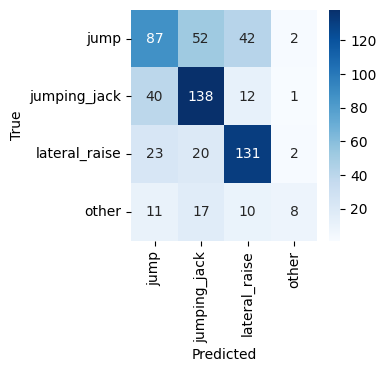

In [72]:
# SVM
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

SVM = SVC(kernel='rbf', gamma=0.1, C=500)
X_train = np.array(X_train)
y_train = np.array(y_train)

SVM.fit(X_train, y_train)
X_test = np.array(X_test)
n_samples = X_test.shape[0]
X_test = X_test.reshape(n_samples, -1)
y_test = np.array(y_test)

y_pred = SVM.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
svm_report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("SVM Classification Report:")
print(svm_report)

cmx = confusion_matrix(y_test, y_pred)
# Get the class labels from LabelEncoder
#class_labels = label_encoder.classes_

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3, 3))
sns.heatmap(cmx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [73]:
#resampling 
def run_kfolds(model, x, y, splits):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")
    predict = cross_val_predict(model, x, y, cv=kf)
    return scores, predict

Accuracy: 0.6035264483627204
SVM Cross Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       599
           1       0.61      0.73      0.66       601
           2       0.67      0.72      0.69       600
           3       0.51      0.14      0.21       185

    accuracy                           0.60      1985
   macro avg       0.58      0.52      0.52      1985
weighted avg       0.59      0.60      0.59      1985



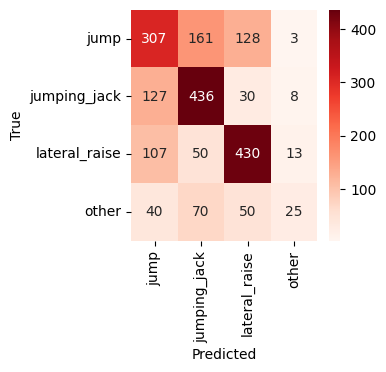

In [74]:
#cross validation

SVM = SVC(kernel='rbf', gamma=0.1, C=500)
svm_scores, svm_predicts = run_kfolds(SVM, shuffle_X, shuffle_y, 5)

# Calculate evaluation metrics
accuracy = accuracy_score(shuffle_y, svm_predicts)
svm_report = classification_report(shuffle_y, svm_predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("SVM Cross Validation Classification Report:")
print(svm_report)

cmx = confusion_matrix(shuffle_y, svm_predicts)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(3,3))
sns.heatmap(cmx, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.6040268456375839
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       167
           1       0.63      0.78      0.69       192
           2       0.67      0.69      0.68       183
           3       0.33      0.04      0.07        54

    accuracy                           0.60       596
   macro avg       0.53      0.50      0.49       596
weighted avg       0.58      0.60      0.58       596



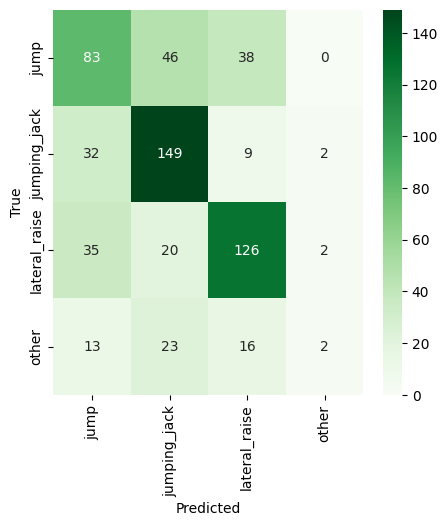

In [75]:
# RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(flattened_descriptors, encoded_labels, test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rf_report = classification_report(y_test, y_pred)
print("Random Forest Classification Report:")
print(rf_report)

cmx = confusion_matrix(y_test, y_pred)

classes = label_encoder.classes_

plt.figure(figsize=(5, 5))
sns.heatmap(cmx, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy: 0.6050377833753149
Random Forest Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       599
           1       0.60      0.75      0.67       601
           2       0.65      0.72      0.68       600
           3       0.42      0.04      0.08       185

    accuracy                           0.61      1985
   macro avg       0.56      0.51      0.49      1985
weighted avg       0.59      0.61      0.58      1985



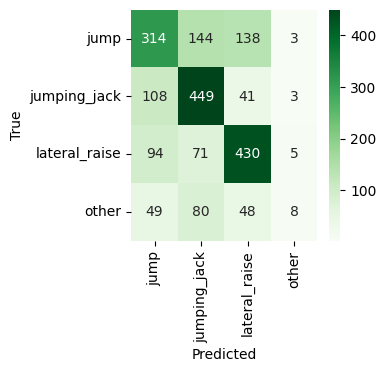

In [76]:
rf = RandomForestClassifier(n_estimators=100)

scores, predicts = run_kfolds(rf, shuffle_X, shuffle_y, 5)

# evaluation metrics
accuracy = accuracy_score(shuffle_y, predicts)
rf_report = classification_report(shuffle_y, predicts)

# Display the evaluation metrics
print("Accuracy:", accuracy)
print("Random Forest Cross-Validation Classification Report:")
print(rf_report)

cm = confusion_matrix(shuffle_y, predicts)
plt.figure(figsize=(3, 3))
class_labels = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens' , xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()